<a href="https://colab.research.google.com/github/SiddheshGaneshChavan/EhnoApp/blob/master/skin_lesion_classification_dermanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from google.colab import files

files.upload()
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip /content/skin-cancer-mnist-ham10000.zip

#import os
#for dirname, _, filenames in os.walk('/content/'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

data = pd.read_csv("/content/hmnist_28_28_RGB.csv")
data.head()
meta_df = pd.read_csv("/content/HAM10000_metadata.csv")
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
meta_df.shape
data.shape

(10015, 2353)

In [ ]:
yData = data['label']
XData = data.drop(columns = ['label'])
# EDA
distribution = meta_df['dx'].value_counts()
distribution
# classes = {4: ('nv', ' Nevus'),
#            6: ('mel', 'Melanoma'),
#            2 :('bkl', 'Seborrheic Keratosis'),
#            1:('bcc' , ' Basal Cell Carcinoma '),
#            5: ('vasc', 'Vascular Lesion'),
#            0: ('akiec', 'Actinic Keratosis'),
#            3: ('df', 'Dermatofibroma')}

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


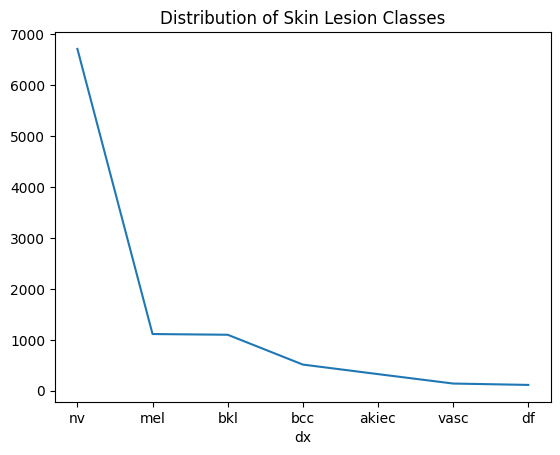

In [ ]:
dist = data['label'].value_counts()
dist
distribution.plot()
plt.title('Distribution of Skin Lesion Classes')
plt.show()

In [ ]:
# Fixing Data Imbalance
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
XData,yData  = sampler.fit_resample(XData,yData)
XData.shape, yData.shape
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape

(46935, 28, 28, 3)

In [ ]:
# Creating the train and validation set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape

((37548, 28, 28, 3), (9387, 28, 28, 3))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, ZeroPadding2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

input_shape = (28, 28, 3)
num_classes = 7

## Hybrid CNN (Base Paper)

### Model Architecture
![Screenshot 2024-09-09 at 11.54.31 AM.png](attachment:3d722e98-0021-4746-a50d-2f660b761188.png)

In [ ]:
# Convolution Block
def conv_block(x, filters, kernel_size, strides=1, padding='same'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# Identity Block (used in ResNet for residual connections)
def identity_block(x, filters):
    skip = x
    x = conv_block(x, filters, 3)
    x = conv_block(x, filters, 3)
    x = layers.Add()([x, skip])
    return x

# Dense Block (used in DenseNet)
def dense_block(x, num_layers, growth_rate):
    for i in range(num_layers):
        layer = conv_block(x, growth_rate, 3)
        x = layers.Concatenate()([x, layer])
    return x

# Transition Block (used in DenseNet to reduce dimensions)
def transition_block(x, filters):
    x = layers.Conv2D(filters, 1, padding='same')(x)
    x = layers.AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

# Define the Hybrid CNN model
def hybrid_cnn_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Convolution and Pooling layers
    #Consists of a Conv2D layer followed by BatchNormalization and ReLU activation. This is a common pattern to enhance model training stability and convergence speed.
    x = conv_block(inputs, 64, 7, strides=2)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Conv Block A, B, and C (Conv blocks can be repeated with different filters)
    x = conv_block(x, 64, 3)
    x = conv_block(x, 128, 3)
    x = conv_block(x, 256, 3)

    # Adding an Identity Block (ResNet style)
    x = identity_block(x, 256)

    # Introduces residual connections (skip connections) similar to ResNet. These help with training deeper networks by
    #allowing gradients to bypass certain layers, preventing vanishing gradients.

    x = transition_block(x, 128)

    # Dense Block (Growth rate 32 and 6 layers in this example)
    #Creates a block similar to DenseNet, where feature maps from previous layers are concatenated (feature reuse),
    #leading to more efficient propagation of information through the network.
    x = dense_block(x, 6, 32)

    # Pooling (Averaging)
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected (FC) Layer
    #Reduces the number of feature maps using a Conv2D with 1x1 filters followed by average pooling, which is a typical step in DenseNet to downsample the features.
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer with Softmax for multi-class classification
    #Combines convolutional, identity (ResNet-style), and dense (DenseNet-style) blocks.
#The model starts with an initial convolution and max pooling layer.
#Uses convolutional layers with increasing filter sizes, then adds an identity block for residual learning.
    outputs = layers.Dense(7, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs, outputs)

    return model


HybridCNN = hybrid_cnn_model(input_shape, num_classes)

HybridCNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = HybridCNN.fit(Xtrain,
                    Ytrain,
                    epochs = 10,
                    validation_data = (Xtest, Ytest))

Epoch 1/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.4808 - loss: 1.3529 - val_accuracy: 0.4852 - val_loss: 1.7410
Epoch 2/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7011 - loss: 0.8090 - val_accuracy: 0.6345 - val_loss: 1.1674
Epoch 3/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7774 - loss: 0.6081 - val_accuracy: 0.5899 - val_loss: 1.4305
Epoch 4/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8127 - loss: 0.5016 - val_accuracy: 0.4370 - val_loss: 3.0047
Epoch 5/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8486 - loss: 0.4024 - val_accuracy: 0.4740 - val_loss: 2.9404
Epoch 6/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8721 - loss: 0.3463 - val_accuracy: 0.8152 - val_loss: 0.5343
Epoch 7/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8986 - loss: 0.2824 - val_accuracy: 0.3999 - val_loss: 2.6960
Epoch 8/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9070 -

In [ ]:
from tabulate import tabulate

loss_hybrid_cnn, accuracy_hybrid_cnn = HybridCNN.evaluate(Xtest, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_hybrid_cnn * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_hybrid_cnn)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5413 - loss: 2.3623
+---------------+--------+
| Test Accuracy | 54.11% |
+---------------+--------+
| Test Loss     | 2.3706 |
+---------------+--------+


294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.89      0.64      1324
           1       0.55      0.09      0.15      1344
           2       0.55      0.63      0.59      1362
           3       0.93      0.50      0.65      1353
           4       0.97      0.28      0.43      1339
           5       1.00      0.52      0.69      1340
           6       0.34      0.89      0.49      1325

    accuracy                           0.54      9387
   macro avg       0.69      0.54      0.52      9387
weighted avg       0.69      0.54      0.52      9387



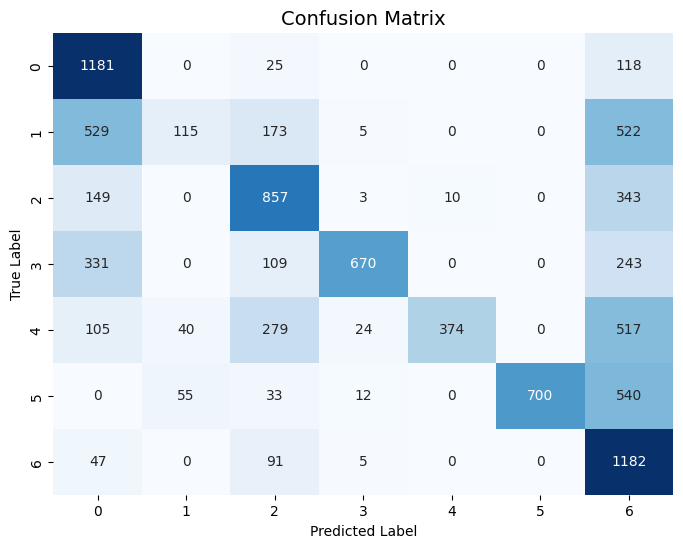

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Ypred_hybrid_cnn = HybridCNN.predict(Xtest)
Ypred_hybrid_cnn = Ypred_hybrid_cnn.argmax(axis=1)  # Assuming one-hot encoded output

print("\n\033[1mClassification Report\033[0m")
print(classification_report(Ytest, Ypred_hybrid_cnn))

conf_matrix = confusion_matrix(Ytest, Ypred_hybrid_cnn)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

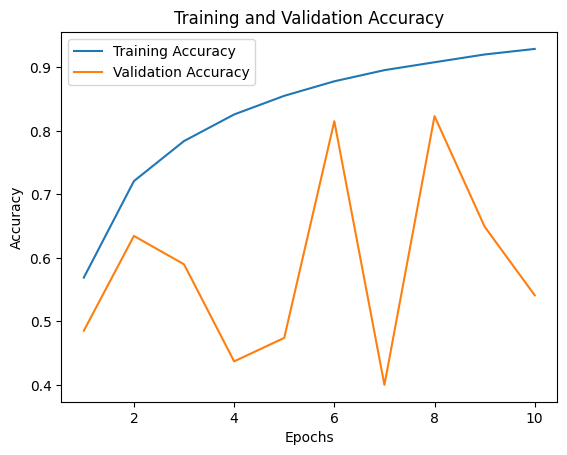

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

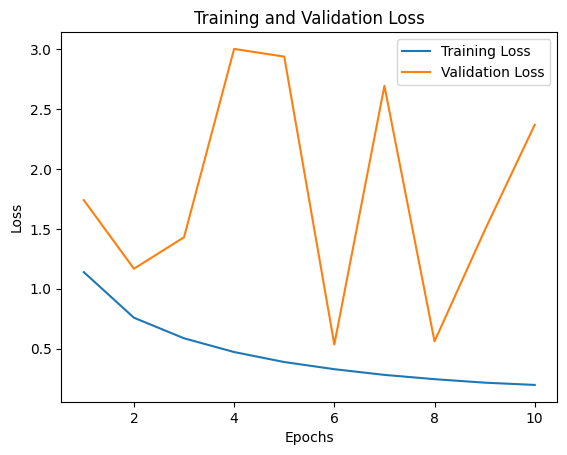

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## DermaNet

In [ ]:
inputs = Input(shape=input_shape)
derma_net = Conv2D(32, (2, 2), padding='same')(inputs)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)
derma_net = MaxPooling2D(pool_size=(2, 2))(derma_net)

derma_net = Conv2D(32, (2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)
derma_net = MaxPooling2D(pool_size=(2, 2))(derma_net)

derma_net = Conv2D(64, (2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)
derma_net = MaxPooling2D(pool_size=(2, 2))(derma_net)

derma_net = SeparableConv2D(128, (2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)
derma_net = SpatialDropout2D(0.2)(derma_net)
derma_net = MaxPooling2D(pool_size=(2, 2))(derma_net)

# Upsampling Layers
derma_net = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)

derma_net = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)

# Global Average Pooling
derma_net = GlobalAveragePooling2D()(derma_net)

# Dense Layers
derma_net = Dense(128)(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = Dropout(0.5)(derma_net)

# More Dense Layers
derma_net = Dense(128)(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = Dropout(0.5)(derma_net)

derma_net = Dense(128)(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = Dropout(0.5)(derma_net)

outputs = Dense(7)(derma_net)
outputs = Activation('softmax')(outputs)

DermaNet = Model(inputs=inputs, outputs=outputs)

DermaNet.compile(loss='sparse_categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

In [ ]:
import pandas as pd
from keras.models import Model
from tabulate import tabulate

layer_info = []

for layer in DermaNet.layers:
    layer_info.append({
        "Layer Name": layer.name,
        "Layer Type": layer.__class__.__name__,
        "Output Shape": str(layer.output.shape) if hasattr(layer, 'output') else "N/A",
        "Param #": layer.count_params(),
    })

layer_df = pd.DataFrame(layer_info)

table_data = layer_df.values.tolist()
table_headers = layer_df.columns.tolist()

print(tabulate(table_data, headers=table_headers, tablefmt='pretty'))


+----------------------------+------------------------+--------------------+---------+
|         Layer Name         |       Layer Type       |    Output Shape    | Param # |
+----------------------------+------------------------+--------------------+---------+
|       input_layer_1        |       InputLayer       | (None, 28, 28, 3)  |    0    |
|         conv2d_13          |         Conv2D         | (None, 28, 28, 32) |   416   |
|         activation         |       Activation       | (None, 28, 28, 32) |    0    |
|   batch_normalization_12   |   BatchNormalization   | (None, 28, 28, 32) |   128   |
|      max_pooling2d_1       |      MaxPooling2D      | (None, 14, 14, 32) |    0    |
|         conv2d_14          |         Conv2D         | (None, 14, 14, 32) |  4128   |
|        activation_1        |       Activation       | (None, 14, 14, 32) |    0    |
|   batch_normalization_13   |   BatchNormalization   | (None, 14, 14, 32) |   128   |
|      max_pooling2d_2       |      MaxPool

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/skin.keras',
                                              monitor='val_acc', mode='max',
                                              verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)


Mounted at /content/drive


In [ ]:
history = DermaNet.fit(Xtrain,
                    Ytrain,
                    epochs = 30,
                    validation_data = (Xtest, Ytest),
                    callbacks=[callback, early_stopping])

Epoch 1/30
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5021 - loss: 1.2683
Epoch 1: saving model to /content/drive/MyDrive/skin.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.5022 - loss: 1.2681 - val_accuracy: 0.6743 - val_loss: 0.8823
Epoch 2/30
1170/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7629 - loss: 0.6609
Epoch 2: saving model to /content/drive/MyDrive/skin.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7630 - loss: 0.6607 - val_accuracy: 0.7009 - val_loss: 1.0320
Epoch 3/30
1173/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8222 - loss: 0.4958
Epoch 3: saving model to /content/drive/MyDrive/skin.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8222 - loss: 0.4958 - val_accuracy: 0.8358 - val_loss: 0.4250
Epoch 4/30
1170/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8496 - loss: 0.4157
Epoch 4: saving model to /content/drive/MyDrive/skin.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accurac

In [ ]:
from tabulate import tabulate

loss_dermanet, accuracy_dermanet = DermaNet.evaluate(Xtest, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_dermanet * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_dermanet)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9712 - loss: 0.0880
+---------------+--------+
| Test Accuracy | 97.14% |
+---------------+--------+
| Test Loss     | 0.0879 |
+---------------+--------+


294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1324
           1       0.98      1.00      0.99      1344
           2       0.92      1.00      0.96      1362
           3       1.00      1.00      1.00      1353
           4       0.97      0.84      0.90      1339
           5       1.00      1.00      1.00      1340
           6       0.94      0.96      0.95      1325

    accuracy                           0.97      9387
   macro avg       0.97      0.97      0.97      9387
weighted avg       0.97      0.97      0.97      9387



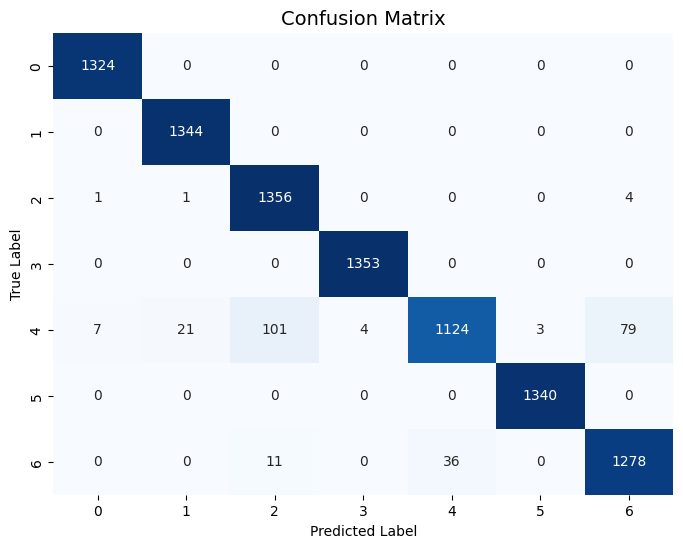

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Ypred = DermaNet.predict(Xtest)
Ypred = Ypred.argmax(axis=1)

print("\n\033[1mClassification Report\033[0m")
print(classification_report(Ytest, Ypred))

conf_matrix = confusion_matrix(Ytest, Ypred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

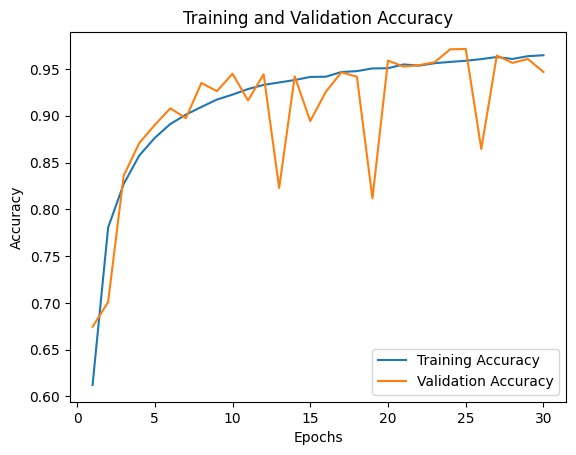

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

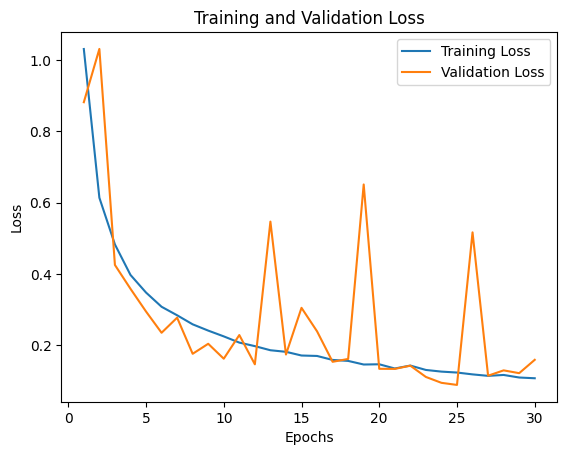

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## EfficientNet

In [ ]:
Xtrain_resized = tf.image.resize(Xtrain, (32, 32))
Xtest_resized = tf.image.resize(Xtest, (32, 32))

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

Efficientnet = Model(inputs=base_model.input, outputs=predictions)

Efficientnet.compile(optimizer='adagrad', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = Efficientnet.fit(Xtrain_resized, Ytrain,
                           validation_data=(Xtest_resized, Ytest),
                           epochs=10)

Epoch 1/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 120s 53ms/step - accuracy: 0.2785 - loss: 1.8346 - val_accuracy: 0.5748 - val_loss: 1.2054
Epoch 2/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 74s 21ms/step - accuracy: 0.5365 - loss: 1.2577 - val_accuracy: 0.7044 - val_loss: 0.8921
Epoch 3/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.6293 - loss: 1.0211 - val_accuracy: 0.7641 - val_loss: 0.7049
Epoch 4/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.6794 - loss: 0.8883 - val_accuracy: 0.8082 - val_loss: 0.6084
Epoch 5/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.7170 - loss: 0.7933 - val_accuracy: 0.8278 - val_loss: 0.5307
Epoch 6/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7404 - loss: 0.7229 - val_accuracy: 0.8476 - val_loss: 0.4755
Epoch 7/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.7614 - loss: 0.6617 - val_accuracy: 0.8568 - val_loss: 0.4298
Epoch 8/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.7800 

In [ ]:
from tabulate import tabulate

loss_efficientnet, accuracy_efficientnet = Efficientnet.evaluate(Xtest_resized, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_efficientnet * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_efficientnet)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8853 - loss: 0.3387
+---------------+--------+
| Test Accuracy | 88.55% |
+---------------+--------+
| Test Loss     | 0.3421 |
+---------------+--------+


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Ypred = Efficientnet.predict(Xtest_resized)
Ypred = Ypred.argmax(axis=1)

print("\n\033[1mClassification Report\033[0m")
print(classification_report(Ytest, Ypred))

294/294 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1324
           1       0.91      0.96      0.93      1344
           2       0.80      0.77      0.79      1362
           3       0.98      1.00      0.99      1353
           4       0.83      0.68      0.74      1339
           5       0.98      0.99      0.98      1340
           6       0.77      0.81      0.79      1325

    accuracy                           0.89      9387
   macro avg       0.88      0.89      0.88      9387
weighted avg       0.88      0.89      0.88      9387



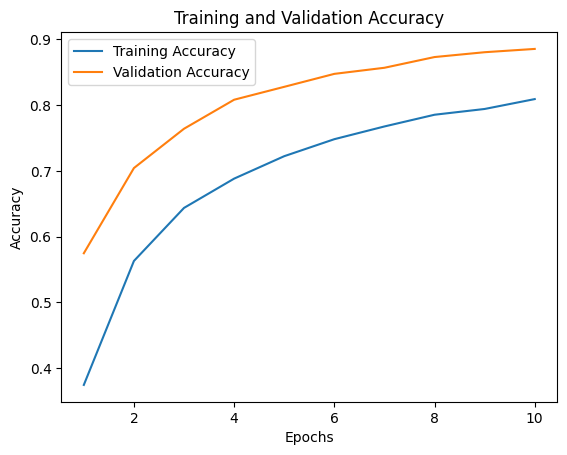

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

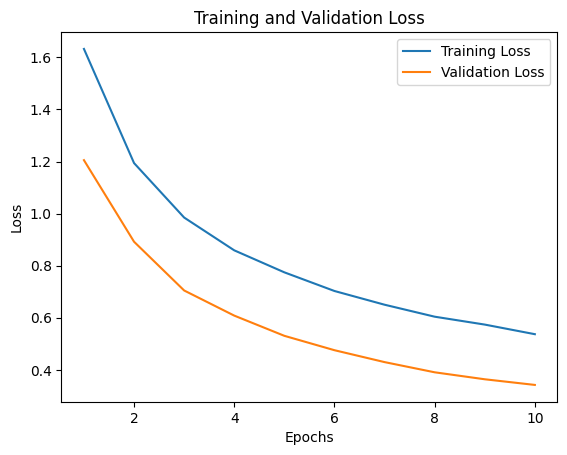

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Resnet50

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

Resnet = Model(inputs=base_model.input, outputs=predictions)

Resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history = Resnet.fit(Xtrain_resized, Ytrain,
                           validation_data=(Xtest_resized, Ytest),
                           epochs=20)

Epoch 1/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 143s 69ms/step - accuracy: 0.5828 - loss: 1.2768 - val_accuracy: 0.7151 - val_loss: 0.8169
Epoch 2/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 75s 34ms/step - accuracy: 0.8205 - loss: 0.5151 - val_accuracy: 0.7297 - val_loss: 0.9192
Epoch 3/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.8503 - loss: 0.4330 - val_accuracy: 0.7430 - val_loss: 0.7299
Epoch 4/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8720 - loss: 0.3773 - val_accuracy: 0.1532 - val_loss: 87.8104
Epoch 5/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.8607 - loss: 0.4004 - val_accuracy: 0.3225 - val_loss: 3.7030
Epoch 6/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8704 - loss: 0.3775 - val_accuracy: 0.8518 - val_loss: 0.4879
Epoch 7/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.9320 - loss: 0.1965 - val_accuracy: 0.5253 - val_loss: 1.7144
Epoch 8/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.8987

In [ ]:
from tabulate import tabulate

loss_resnet, accuracy_resnet = Resnet.evaluate(Xtest_resized, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_resnet * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_resnet)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9561 - loss: 0.1666
+---------------+--------+
| Test Accuracy | 95.74% |
+---------------+--------+
| Test Loss     | 0.1600 |
+---------------+--------+


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Ypred = Resnet.predict(Xtest_resized)
Ypred = Ypred.argmax(axis=1)

print("\n\033[1mClassification Report\033[0m")
print(classification_report(Ytest, Ypred))

294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1324
           1       0.99      0.98      0.98      1344
           2       0.91      0.98      0.94      1362
           3       1.00      0.97      0.99      1353
           4       0.95      0.81      0.88      1339
           5       1.00      0.99      0.99      1340
           6       0.90      0.97      0.93      1325

    accuracy                           0.96      9387
   macro avg       0.96      0.96      0.96      9387
weighted avg       0.96      0.96      0.96      9387



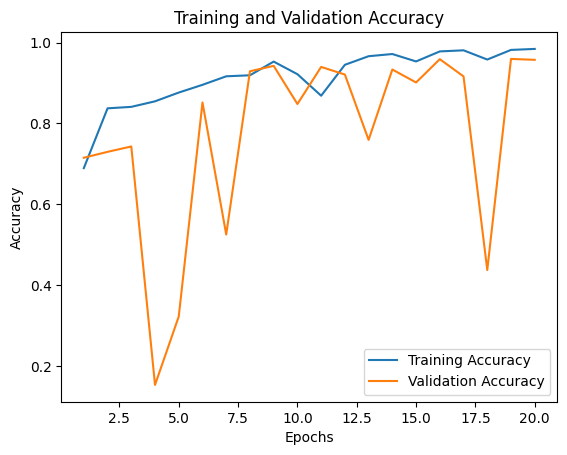

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

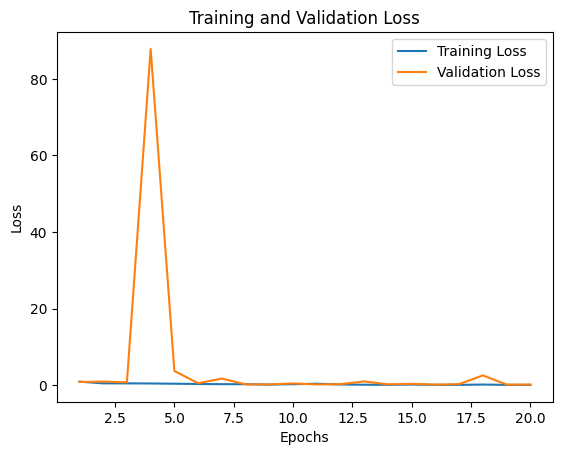

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Models Comparison

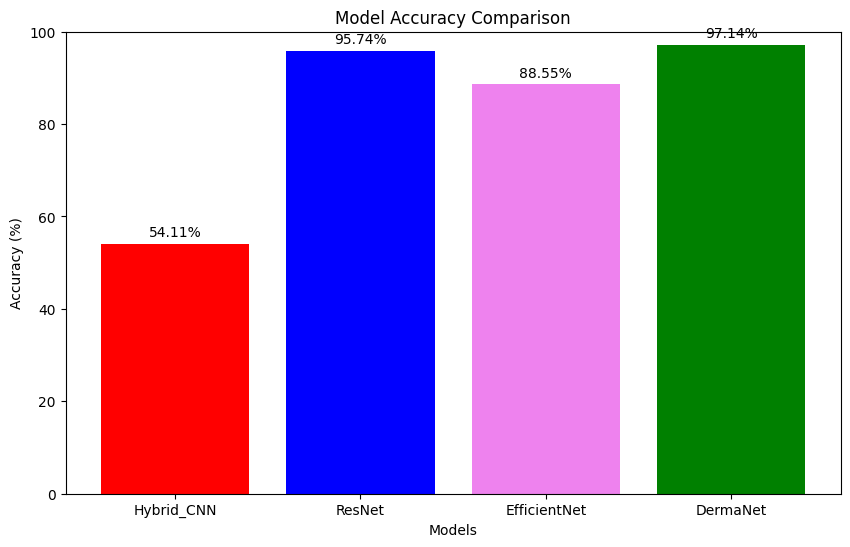

In [ ]:
import matplotlib.pyplot as plt

accuracies = [accuracy_hybrid_cnn*100, accuracy_resnet*100, accuracy_efficientnet*100 , accuracy_dermanet*100]
models = ['Hybrid_CNN', 'ResNet', 'EfficientNet' ,"DermaNet"]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['red', 'blue', 'violet','green'])

plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.ylim(0, 100)
plt.show()

## Model Prediction

294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


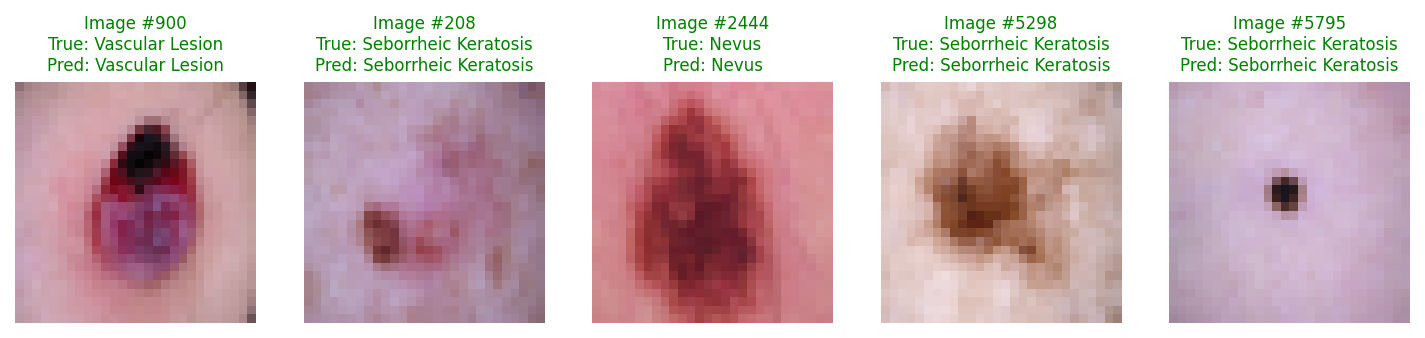

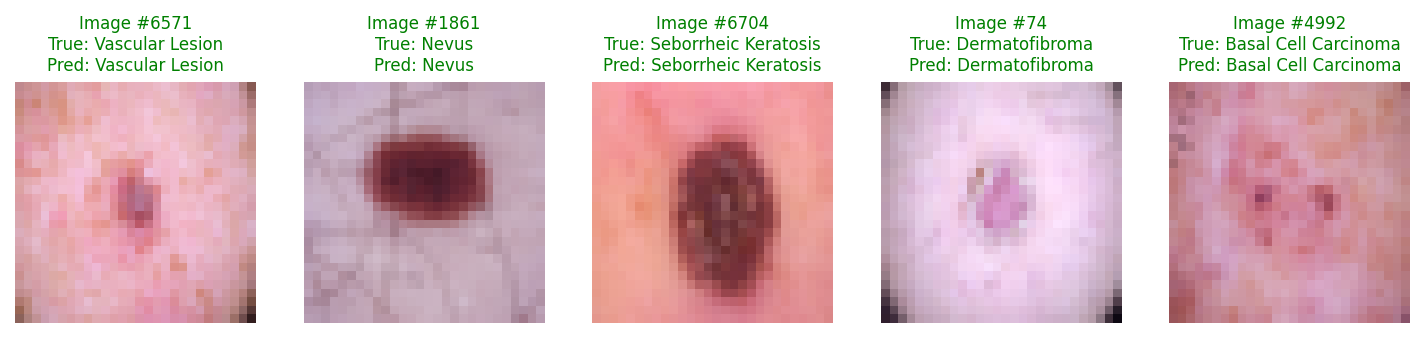

In [ ]:
Ytest = np.array(Ytest)
import numpy as np
import matplotlib.pyplot as plt
classes = {
    4: ('Nevus'),
    6: ('Melanoma'),
    2: ('Seborrheic Keratosis'),
    1: ('Basal Cell Carcinoma'),
    5: ('Vascular Lesion'),
    0: ('Actinic Keratosis'),
    3: ('Dermatofibroma')
}

test_pred = DermaNet.predict(Xtest)

test_pred = np.argmax(test_pred, axis=1)

def random_test_sample_with_prediction(SEED):
    num_samples = len(Xtest)
    idxs = np.random.default_rng(seed=SEED).permutation(num_samples)[:5]


    fig, axs = plt.subplots(1, 5, figsize=(12, 12), dpi=150)

    for i, idx in enumerate(idxs):

        img = Xtest[idx]
        true_label = Ytest[idx]
        pred_label = test_pred[idx]

        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')

        title_color = 'green' if true_label == pred_label else 'red'
        axs[i].set_title(f"Image #{idx}\nTrue: {classes[true_label]}\nPred: {classes[pred_label]}",
                         fontsize=8, color=title_color)

random_test_sample_with_prediction(SEED=42)
random_test_sample_with_prediction(SEED=120)